In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import datawig
from missingpy import MissForest

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('./data/galaxy.csv')

In [3]:
df.head()

,BuyItNow,startprice,carrier,color,productline,noDescription,charCountDescription,upperCaseDescription,sold
0,0,199.99,None,White,Galaxy_S9,contains description,0,0,1
1,0,235.00,None,NaN,Galaxy_Note9,contains description,0,0,0
2,0,199.99,NaN,NaN,Unknown,no description,100,2,0
3,1,175.00,AT&T,Space Gray,Galaxy_Note9,contains description,0,0,1
4,1,100.00,None,Space Gray,Galaxy_S8,contains description,0,0,1


In [4]:
len(df)

1485

In [170]:
df.columns

Index(['BuyItNow', 'startprice', 'carrier', 'color', 'productline',
       'noDescription', 'charCountDescription', 'upperCaseDescription',
       'sold'],
      dtype='object')

In [171]:
df.color.unique()

array(['White', nan, 'Space Gray', 'Midnight Black', 'Aura Black', 'Gold',
       'Black', 'Prism Black'], dtype=object)

In [172]:
df.carrier.unique()

array(['None', nan, 'AT&T', 'Sprint/T-Mobile', 'Verizon'], dtype=object)

# Ebay auction sales for Samsung Galaxy

Webpage : http://ebay.auction.co.kr/shop/itms?sk_idx=0&q=galaxy&sk=galaxy&ltype=Auction

### Feature

- BuyItNow
    - 즉시구매상품 여부 (즉시구매상품이면 1, 경매 상품이면 0)
        - 즉시구매상품일 경우, `startprice`와 함께 즉시구매가격이 설정됨 (즉시구매가 정보는 데이터 미포함)
    - source: https://pics.ebay.com/aw/pics/pdf/us/file_exchange/File_Exchange_Advanced_Instructions.pdf
- color
    - 핸드폰 색상
    - 모든 모델에 대해 공통적으로 적용되는 색상이 아님
        - Prism Black은 S10 라인업에서 처음 등장한 색상
    - 희소성 측면에서, 일부 색상은 가격과 관련된 정보를 일부 포함할 가능성이 존재함
        - research 진행하여, 희소성이 존재하는 한정 색상일 경우 별도 컬럼으로 구분하는 방법을 검토
- carrier
    - 통신사 정보
        - 통신사 요금제는 Verizon > AT&T > Sprint/T-Mobile 순으로 가격이 비쌈
        - 크레딧 스토어가 없거나 계좌 개설이 어려운 상황일 경우, 무제한 데이터 요금을 쓰지 않을 경우 통신사를 사용하지 않음
        - source https://miguksaram.tistory.com/19
    - 통신사 정보가 핸드폰 사용자의 경제력 또는 구매력에 대한 정보를 일부 포함할 가능성이 존재함

<AxesSubplot:>

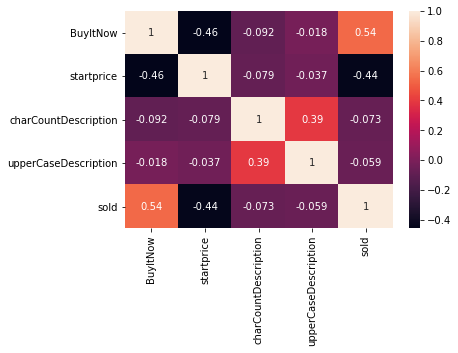

In [173]:
sns.heatmap(df.corr(), annot=True)

# `BuyItNow` & `startprice`
- 즉시구매상품과 경매상품 간에 명확한 startprice 분포 차이가 존재함

In [174]:
df_buyitnow_0 = df[df['BuyItNow']==0]
df_buyitnow_1 = df[df['BuyItNow']==1]

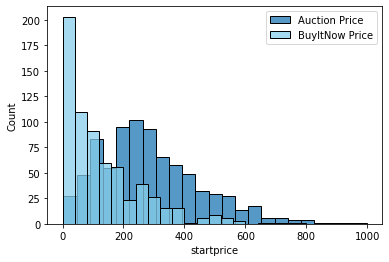

In [175]:
sns.histplot(df_buyitnow_0['startprice'])
sns.histplot(df_buyitnow_1['startprice'], color='skyblue')
plt.legend(['Auction Price', 'BuyItNow Price'])

### 모델별 평균가를 기준으로 분포를 비교해 본다면?

In [120]:
df.columns

Index(['BuyItNow', 'startprice', 'carrier', 'color', 'productline',
       'noDescription', 'charCountDescription', 'upperCaseDescription',
       'sold'],
      dtype='object')

<AxesSubplot:xlabel='productline', ylabel='startprice'>

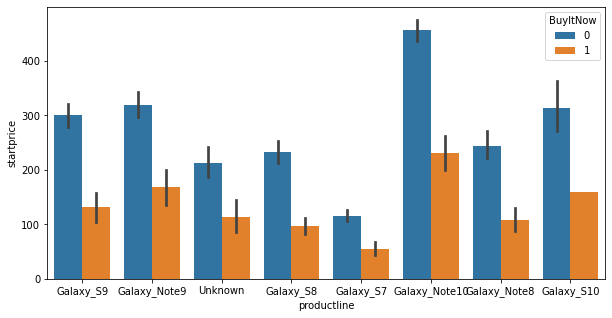

In [257]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df,
            x="productline",
            y="startprice",
            hue="BuyItNow")

In [125]:
df_buyitnow_0['productline'].value_counts()

Galaxy_Note10    211
Galaxy_S8        141
Unknown          120
Galaxy_S7        109
Galaxy_S9         93
Galaxy_Note8      76
Galaxy_Note9      61
Galaxy_S10         7
Name: productline, dtype: int64

In [126]:
df_buyitnow_1['productline'].value_counts()

Galaxy_Note10    140
Galaxy_S8        136
Galaxy_S7        118
Unknown           84
Galaxy_Note8      77
Galaxy_S9         65
Galaxy_Note9      46
Galaxy_S10         1
Name: productline, dtype: int64

### takeaways
- BuyItNow=1일 때의 startprice가 BuyItNow=0일 때의 startprice보다 2배 가량 낮다.
    - 즉시구매가격을 설정한 셀러는 즉시구매가에 팔고 싶은 사람들
    - 높은 가격을 받기에는 경매가 유리한데, 왜 즉시구매가격을 설정할까?
- [웹사이트 확인 결과](http://ebay.auction.co.kr/shop/itms?sk_idx=0&q=galaxy%20s7&sk=galaxy%20s7&ltype=Auction), 즉시구매가 설정된 제품 대부분은 "중고 제품", 경매 only 제품 대부분은 "미사용 제품"
    - 일정한 중고거래가 consensus 형성되어 있으므로 즉시구매가를 설정
    - 중고 제품이므로 미사용 제품 대비 가격대가 낮게 설정됨
    
> BuyItNow는 중고 매물 여부 정보를 포함하며, 가격에 중요한 설명력을 갖는 변수.

# Description 관련 변수들
- `noDescription`
- `charCountDescription`
- `upperCaseDescription`

In [13]:
df['charCountDescription'].unique()

array([  0, 100,  92,  96,  98,  84,  16, 101,  71,  77,  20,  14,  81,
        11,   8,  31,  70,  93,  86,  25,  99,  37,  95,  21,  43,  33,
       105, 102,  61,  44,  75,  40,  55,  19,  78,  58,  13,  87,  54,
        46,  80,  50,  89,  73,  18,  41,  49,  30,  97,  94,  39,  68,
        26,  15,  88,  34, 108,  57,  59,  32,  62,  38, 103,  17,  47,
        69,  82,  24,  67,  83,  91,   9,  45,  72,  76,  52,  35,  79,
       106,  29,  48,  12,   4,  56,  65,  64,  27,  60,  63,  74,   3,
        36,  28,  22,  85,   5, 104,  90,  42,   6, 109, 111,  10,  53,
        51])

In [14]:
df['charCountDescription'].value_counts()

0      856
99      56
100     50
101     43
98      40
      ... 
28       1
63       1
109      1
53       1
111      1
Name: charCountDescription, Length: 105, dtype: int64

In [37]:
df.describe()

,BuyItNow,startprice,charCountDescription,upperCaseDescription,sold
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,0.449158,216.844162,31.184512,2.863300,0.461953
std,0.497576,172.893308,41.744518,9.418585,0.498718
min,0.000000,0.010000,0.000000,0.000000,0.000000
25%,0.000000,80.000000,0.000000,0.000000,0.000000
50%,0.000000,198.000000,0.000000,0.000000,0.000000
75%,1.000000,310.000000,79.000000,2.000000,1.000000
max,1.000000,999.000000,111.000000,81.000000,1.000000


In [69]:
df_has_char_desc = df[df['charCountDescription'] > 0]
df_no_char_desc = df[df['charCountDescription'] == 0]

In [70]:
len(df_has_char_desc), len(df_no_char_desc)

(629, 856)

In [71]:
df_has_char_desc['sold'].sum() / len(df[df['charCountDescription'] > 0])

0.43402225755166934

In [72]:
df_no_char_desc['sold'].sum() / len(df_no_char_desc)

0.4824766355140187

### startprice에 대해서 유의미한 분포 차이를 보임

<AxesSubplot:xlabel='startprice', ylabel='Count'>

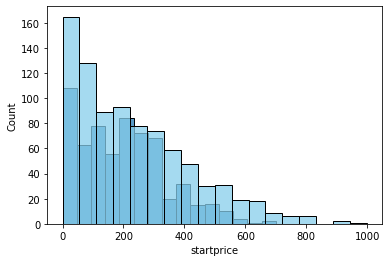

In [73]:
sns.histplot(df_has_char_desc['startprice'])
sns.histplot(df_no_char_desc['startprice'], color='skyblue')

### `charCountDescription`, `charCountDescription`
- 있냐, 없냐 정보만을 표시하는 binary type으로 변경
    - binary 변경할 경우, `charCountDescription`은 `noDescription`과 동일한 정보이므로 삭제
    
### `noDescription` -> binarize
- 데이터 표현이 직관적이지 않은 상태
    - 설명 텍스트가 존재하지 않을 경우 'contains description'라고 표현
    - 설명 텍스트가 존재할 경우 'no description'라고 표현
    > contains description = 0 (실제로는 설명 문구가 없으므로)
    
    > no description = 1 (실제로는 설명 문구가 있으므로)

In [176]:
df = df.drop('charCountDescription', axis=1)
df['upperCaseDescription'] = df['upperCaseDescription'].apply(lambda x: 0 if x == 0 else 1)
df['noDescription'] = df['noDescription'].apply(lambda x: 0 if x.startswith('c') else 1)
df.rename(columns={'noDescription':'hasDescription'}, inplace=True)

In [178]:
df

,BuyItNow,startprice,carrier,color,productline,hasDescription,upperCaseDescription,sold
0,0,199.99,None,White,Galaxy_S9,0,0,1
1,0,235.00,None,NaN,Galaxy_Note9,0,0,0
2,0,199.99,NaN,NaN,Unknown,1,1,0
3,1,175.00,AT&T,Space Gray,Galaxy_Note9,0,0,1
4,1,100.00,None,Space Gray,Galaxy_S8,0,0,1
...,...,...,...,...,...,...,...,...
1480,0,89.50,AT&T,NaN,Galaxy_S7,1,1,0
1481,0,239.95,None,Midnight Black,Galaxy_S9,1,1,1
1482,0,329.99,None,Space Gray,Galaxy_Note10,1,1,0
1483,0,89.00,None,Midnight Black,Galaxy_S7,1,1,1


# `productline`
제품 모델(기종 라인업) 정보
- 각각의 productline 문자열 값
    - 출시 순서 정보를 포함하고 있음 (with order = ordinal)
    - Note 모델인지, Non-Note 모델인지 정보를 포함하고 있음 (binary)
- 'unknown' 값은 결측치에 해당
    - **204개**, 전체 데이터 샘플(1500개) 대비 무시할 수 없는 수준
    - 'unknown' 자체를 하나의 정보로 사용할 수도 있고, nan으로 변환한 뒤 imputation 할 수도 있음

> 출시 순서 정보와 Note 모델 여부 정보를 2개의 컬럼으로 별도 구분


In [77]:
df['productline'].unique()

array(['Galaxy_S9', 'Galaxy_Note9', 'Unknown', 'Galaxy_S8', 'Galaxy_S7',
       'Galaxy_Note10', 'Galaxy_Note8', 'Galaxy_S10'], dtype=object)

In [78]:
len(df[df['productline']=='Unknown'])

204

In [363]:
# 출시 시기와 모델 정보, 2개의 정보를 별도의 컬럼으로 구분

# 출시 시기 정보
# 빨리 나온 순서대로 1부터 ++1 순차 넘버링 (ordinal type)
df['modelNumber'] = df['productline'].apply(lambda x: int(x.split('_')[1].strip('S').strip('Note'))-6
                                            if x != 'Unknown' else x)

# 노트 모델인지 일반 모델인지 정보 (binary type)
df['isNote'] = df['productline'].apply(lambda x: x if x == 'Unknown' else 1 if 'Note' in x else 0)


In [84]:
# 일단 결측치임을 표시하기 위하여 'Unknown'값은 nan으로 변환
# df.loc[df['productline']=='Unknown', 'productline'] = np.nan

# productline 칼럼 드랍 --- 나중에 한번에 드랍?
# df = df.drop('productline', axis=1)

In [181]:
df.head() # productline은 추후 필요에 따라 drop하거나 포함하여 사용한다.

,BuyItNow,startprice,carrier,color,productline,hasDescription,upperCaseDescription,sold,modelNumber,isNote
0,0,199.99,None,White,Galaxy_S9,0,0,1,3,0
1,0,235.00,None,NaN,Galaxy_Note9,0,0,0,3,1
2,0,199.99,NaN,NaN,Unknown,1,1,0,Unknown,Unknown
3,1,175.00,AT&T,Space Gray,Galaxy_Note9,0,0,1,3,1
4,1,100.00,None,Space Gray,Galaxy_S8,0,0,1,2,0


<AxesSubplot:xlabel='startprice', ylabel='Count'>

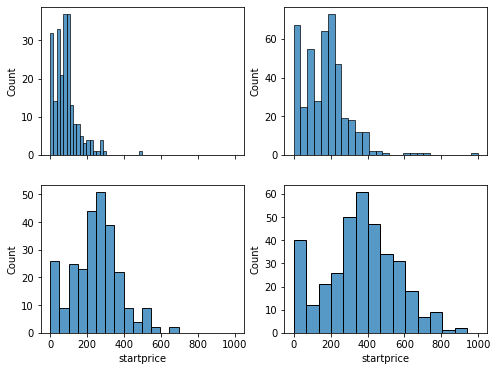

In [95]:
f, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
sns.histplot(df[df['modelNumber']==1].startprice, ax=axes[0][0])
sns.histplot(df[df['modelNumber']==2].startprice, ax=axes[0][1])
sns.histplot(df[df['modelNumber']==3].startprice, ax=axes[1][0])
sns.histplot(df[df['modelNumber']==4].startprice, ax=axes[1][1])

<AxesSubplot:xlabel='startprice', ylabel='Count'>

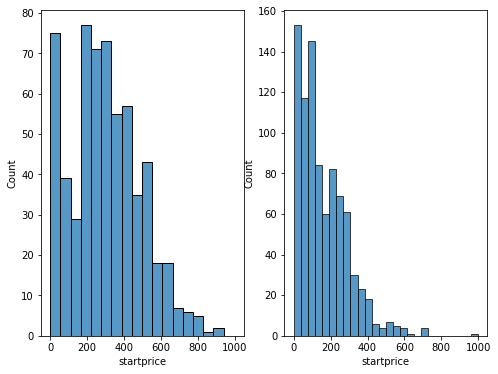

In [96]:
# isNote는 가격 수준에 대하여 유의미한 분포 차이를 나타냄
f, axes = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
sns.histplot(df[df['isNote']==1].startprice, ax=axes[0])
sns.histplot(df[df['isNote']==0].startprice, ax=axes[1])

# `carrier`
- `None`, `AT&T`, `Verizon`, `Sprint/T-Mobile` 간 유의미한 차이가 존재하는가?

<AxesSubplot:xlabel='startprice', ylabel='Count'>

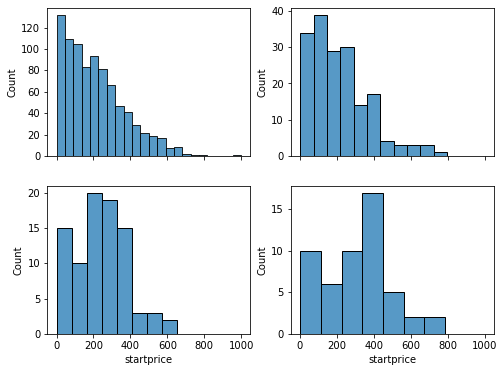

In [130]:
f, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
sns.histplot(df[df['carrier']=='None'].startprice, ax=axes[0][0])
sns.histplot(df[df['carrier']=='AT&T'].startprice, ax=axes[0][1])
sns.histplot(df[df['carrier']=='Verizon'].startprice, ax=axes[1][0])
sns.histplot(df[df['carrier']=='Sprint/T-Mobile'].startprice, ax=axes[1][1])

In [161]:
def draw_carrier_user_startprice_by_productline(carrier_name, exclude=False):
    
    if not exclude:
        df_carrier = df[df['carrier']==carrier_name]
    else:
        df_carrier = df[df['carrier']!=carrier_name]
    df_productline_unique = ['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9',
                             'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']
    print(df_productline_unique)
    f, axes = plt.subplots(4, 2, figsize=(8, 6), sharex=True)
    for i in range(4):
        for j in range(2):
            idx = 2*(i+1) + (j-2)
            sns.histplot(df_carrier[df_carrier['productline']==df_productline_unique[idx]].startprice, ax=axes[i][j])


['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


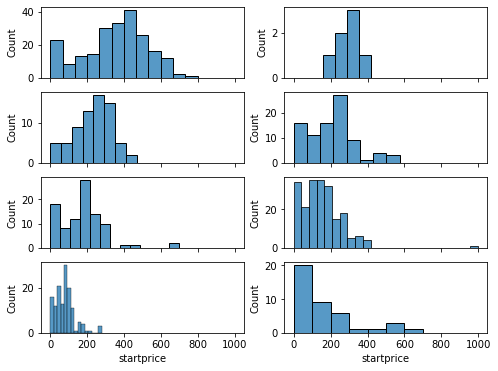

In [162]:
draw_carrier_user_startprice_by_productline('None')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


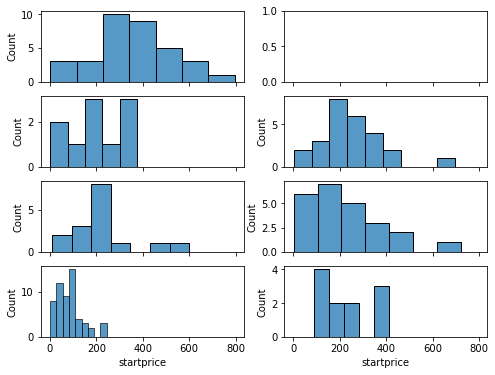

In [145]:
draw_carrier_user_startprice_by_productline('AT&T')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


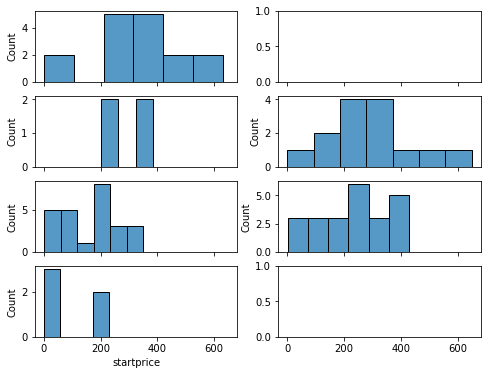

In [146]:
draw_carrier_user_startprice_by_productline('Verizon')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


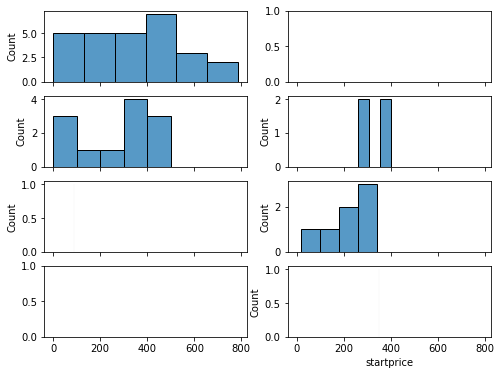

In [147]:
draw_carrier_user_startprice_by_productline('Sprint/T-Mobile')

In [155]:
# 구매를 결정한 비율의 차이는?
print(f'''
None users buying rate = {df[df['carrier'] == 'None']['sold'].mean()}\n
AT&T users buying rate = {df[df['carrier'] == 'AT&T']['sold'].mean()}\n
Verizon users buying rate = {df[df['carrier'] == 'Verizon']['sold'].mean()}\n
Sprint/T-Mobile users buying rate = {df[df['carrier'] == 'Sprint/T-Mobile']['sold'].mean()}
''')


None users buying rate = 0.4820393974507532

AT&T users buying rate = 0.4293785310734463

Verizon users buying rate = 0.5287356321839081

Sprint/T-Mobile users buying rate = 0.46153846153846156



### 차이가 있는지 잘 모르겠다...
- 데이터 갯수 비중에서 `None`이 압도적이므로 엄밀한 비교가 어려움
- `None` vs. `AT&T` + `Verizon` + `Sprint/T-Mobile`은 어떨까?
    - 갯수는 863개 vs. 622개로 대략 비슷한 수준이 됨

In [157]:
df_carrier_none = df[df['carrier'] == 'None']
df_carrier_else = df[df['carrier'] != 'None']

len(df_carrier_none), len(df_carrier_else)

(863, 622)

In [160]:
# buying rate
df_carrier_none['sold'].mean(), df_carrier_else['sold'].mean()

(0.4820393974507532, 0.4340836012861736)

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


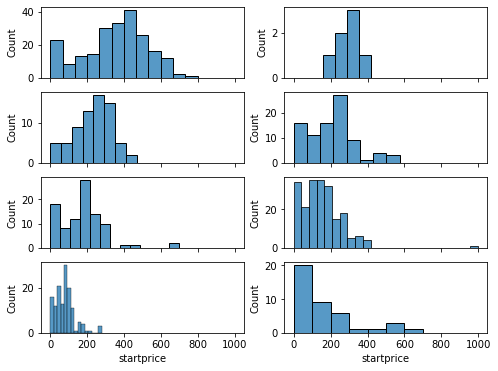

In [163]:
draw_carrier_user_startprice_by_productline('None')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


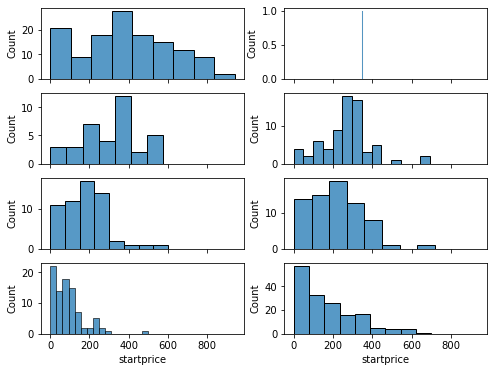

In [164]:
draw_carrier_user_startprice_by_productline('None', exclude=True)

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


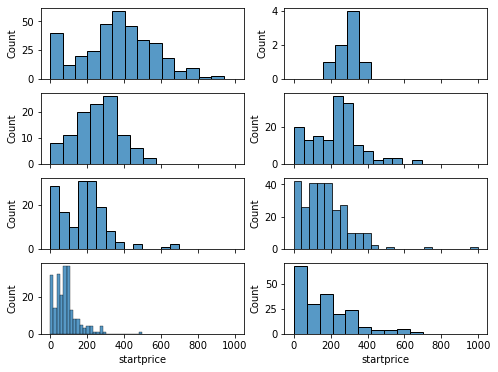

In [165]:
# 통신사를 구분하지 않고 전체 데이터로 그려보면?
draw_carrier_user_startprice_by_productline('', exclude=True)

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


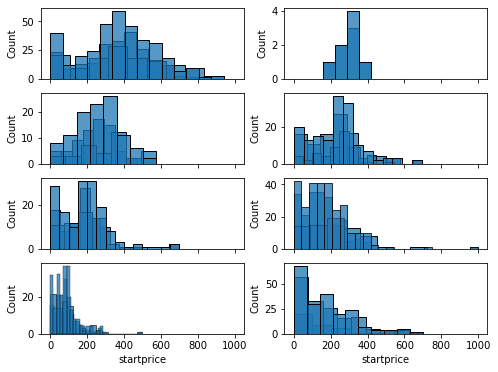

In [166]:
# 모두 겹쳐서 그려보면?
df_productline_unique = ['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9',
                         'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']
print(df_productline_unique)

df_carrier_none = df[df['carrier']=='None']
df_carrier_else_none = df[df['carrier']!='None']
df_carrier_all = df.copy()

f, axes = plt.subplots(4, 2, figsize=(8, 6), sharex=True)
for i in range(4):
    for j in range(2):
        idx = 2*(i+1) + (j-2)
        sns.histplot(df_carrier_none[df_carrier_none['productline']==df_productline_unique[idx]].startprice, ax=axes[i][j])
        sns.histplot(df_carrier_else_none[df_carrier_else_none['productline']==df_productline_unique[idx]].startprice, ax=axes[i][j])
        sns.histplot(df_carrier_all[df_carrier_all['productline']==df_productline_unique[idx]].startprice, ax=axes[i][j])


In [364]:
# 구매를 결정한 비율의 차이는?
print(f'''
None users buying rate = {df[df['carrier'] == 'None']['sold'].mean()}\n
Not-None users buying rate = {df[df['carrier'] != 'None']['sold'].mean()}\n
''')


None users buying rate = 0.4820393974507532

Not-None users buying rate = 0.4340836012861736




In [366]:
df[df['carrier']=='None']['productline'].value_counts()

Galaxy_Note10    219
Galaxy_S8        206
Galaxy_S7        138
Galaxy_Note8      94
Galaxy_S9         87
Galaxy_Note9      71
Unknown           41
Galaxy_S10         7
Name: productline, dtype: int64

In [367]:
df[df['carrier']!='None']['productline'].value_counts()

Unknown          163
Galaxy_Note10    132
Galaxy_S7         89
Galaxy_S9         71
Galaxy_S8         71
Galaxy_Note8      59
Galaxy_Note9      36
Galaxy_S10         1
Name: productline, dtype: int64

In [369]:
print(df[df['carrier']=='None']['startprice'].mean(),
      df[df['carrier']!='None']['startprice'].mean())

207.88530706836613 229.27421221864952


<AxesSubplot:xlabel='startprice', ylabel='Count'>

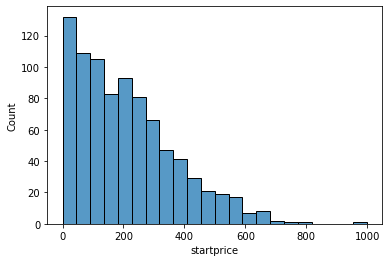

In [370]:
sns.histplot(df[df['carrier']=='None']['startprice'])

<AxesSubplot:xlabel='startprice', ylabel='Count'>

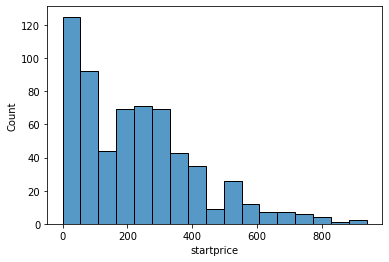

In [371]:
sns.histplot(df[df['carrier']!='None']['startprice'])

### Takeaways on `carrier`
- 유의미한 정보를 갖고 있지 않음
- 충분한 설명력을 갖고 있지 않음
- missing value imputation 가치 없음

> DROP

# `color`
색상 자체의 의미보다는 기종 또는 가격 관련 정보를 추출하는 방향을 고민.

galaxy model|colors available (official name)|colors available (simplified name)
-|-|-
S7|Pink Gold, Black Onyx, Gold Platinum, White Pearl, Silver Titanium|Black, Gold, White, Silver
S8|Midnight Black, Arctic Silver, Maple Gold, Coral Blue, Orchid Gray|Black, Gold, Silver, Blue, Gray
Note8|Midnight Black, Arctic Silver, Orchid Gray/Violet, Coral Blue, Dark Blue, Deep Sea Blue, Pink, Gold|Black, Gold, Silver, Blue, Gray, Pink
S9|Sunrise Gold, Midnight Black, Titanium Gray, Coral Blue, Lilac Purple|Black, Gold, Gray, Blue, Silver
Note9|Midnight Black, Cloud Silver, Lavender Purple, Ocean Blue|Black, Blue, Silver, Purple
S10|Prism White, Prism Black, Prism Green, Prism Blue|Black, White, Blue, Green
Note10|Aura Black, Aura Red, Aura Glow, Aura White|Black, White, Red, Glow

- `Space Gray` = 이런 색은 사용된 적이 없음
    - 단, 회색 색상은 S10 이전 모델만 포함
- `Gold`
    - S10 이전 모델만 포함
- `White`
    - S7, S10, Note10 모델만 포함
- `Midnight Black` = S8, Note8, S9, Note9 고유 블랙 색상
- `Aura Black` = Note10 고유 블랙 색상
- `Prism Black` = Note10+ 고유 블랙 색상

> white, silver, gray 색상은 혼용되어 사용되었을 가능성 높음

> 시그니쳐 컬러인 블랙의 경우에만 일부의 기억하는 응답자가 기록하고, 그 외는 자신이 인식하는 대략적인 색상을 white, gray, black으로 표현한 것으로 보임

> 신뢰할 수 있는 색상은 시그니쳐 컬러인 블랙과 골드 색상

> 그러나 색상이 Gold인 데이터를 조회한 결과, 대부분이 S10/ Note10으로 확인

> color 컬럼의 데이터는 신뢰할 수 없다고 판단하고 삭제

In [352]:
df['color'].value_counts()

White             328
Midnight Black    274
Space Gray        180
Gold               52
Black              38
Aura Black         19
Prism Black         1
Name: color, dtype: int64

In [344]:
df['color'].unique()

array(['White', nan, 'Space Gray', 'Midnight Black', 'Aura Black', 'Gold',
       'Black', 'Prism Black'], dtype=object)

In [353]:
df[df['color']=='White']['productline'].unique()

array(['Galaxy_S9', 'Galaxy_S7', 'Galaxy_Note9', 'Galaxy_Note10',
       'Galaxy_Note8', 'Galaxy_S8', 'Unknown', 'Galaxy_S10'], dtype=object)

In [360]:
df.loc[df['color']=='Gold', ['productline', 'startprice']]

,productline,startprice
56,Unknown,319.00
71,Galaxy_Note10,550.00
182,Galaxy_Note10,480.00
208,Unknown,334.99
213,Galaxy_Note10,320.00
221,Galaxy_Note10,399.00
347,Galaxy_Note10,1.00
407,Galaxy_Note10,425.00
424,Galaxy_Note10,475.00
439,Galaxy_Note10,399.99


In [191]:
df['color'].value_counts().index.tolist() + [np.nan]

['White',
 'Midnight Black',
 'Space Gray',
 'Gold',
 'Black',
 'Aura Black',
 'Prism Black',
 nan]

### 각각의 색상은 얼마나 모델 별 startprice에 영향을 미칠까?

In [206]:
def draw_startprice_distribution_by_color(color_name, exclude=False):
    
    if not exclude:
        df_ = df[df['color']==color_name]
    else:
        df_ = df[df['color']!=color_name]
    #df_color_unq = df['color'].value_counts().index.tolist() + [np.nan]
    df_productline_unique = ['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9',
                             'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']
    print(df_productline_unique)
    f, axes = plt.subplots(4, 2, figsize=(8, 6), sharex=True)
    for i in range(4):
        for j in range(2):
            idx = 2*(i+1) + (j-2)
            sns.histplot(df_[df_['productline']==df_productline_unique[idx]].startprice, ax=axes[i][j])

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


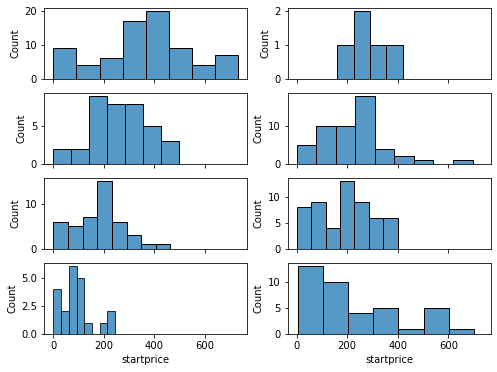

In [207]:
draw_startprice_distribution_by_color('White')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


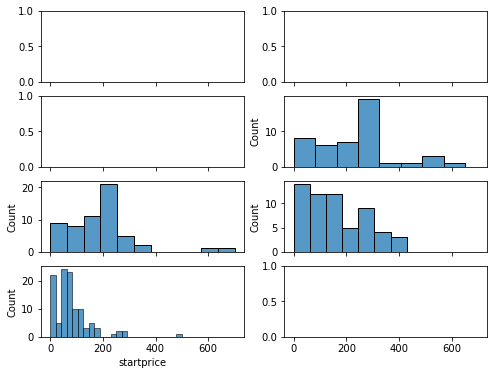

In [208]:
draw_startprice_distribution_by_color('Midnight Black')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


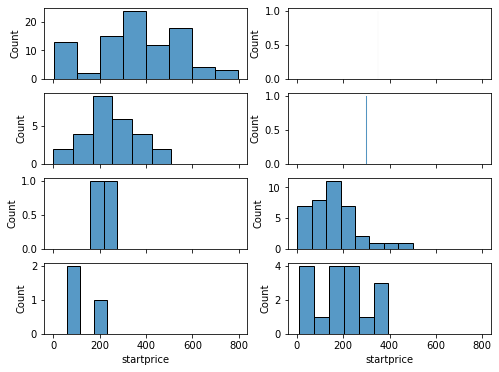

In [209]:
draw_startprice_distribution_by_color('Space Gray')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


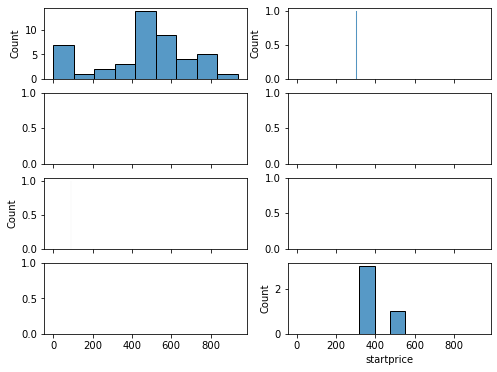

In [210]:
draw_startprice_distribution_by_color('Gold')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


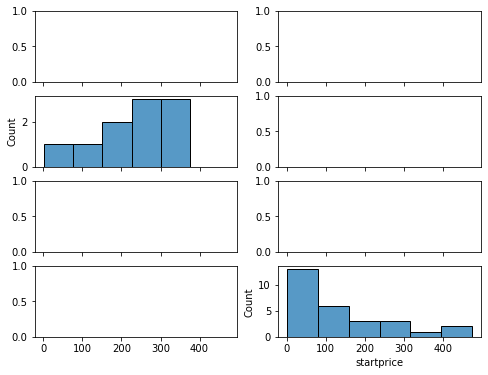

In [211]:
draw_startprice_distribution_by_color('Black')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


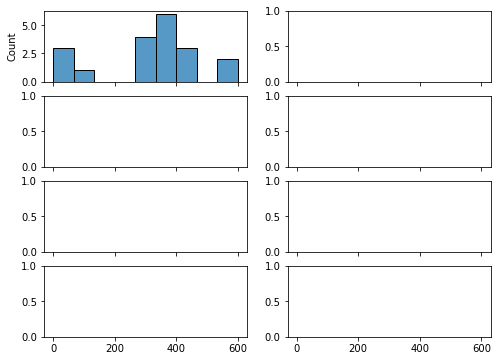

In [212]:
draw_startprice_distribution_by_color('Aura Black')

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


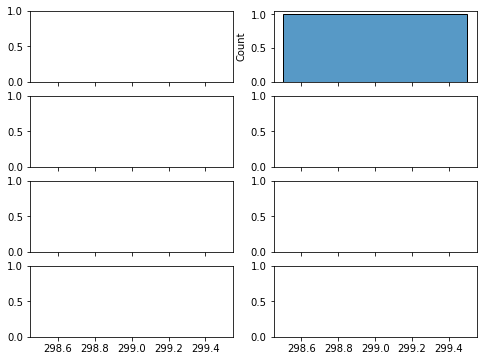

In [213]:
draw_startprice_distribution_by_color('Prism Black')

### 색상 변수를 배제한 순수 모델별 디바이스의 startprice 분포

['Galaxy_Note10', 'Galaxy_S10', 'Galaxy_Note9', 'Galaxy_S9', 'Galaxy_Note8', 'Galaxy_S8', 'Galaxy_S7', 'Unknown']


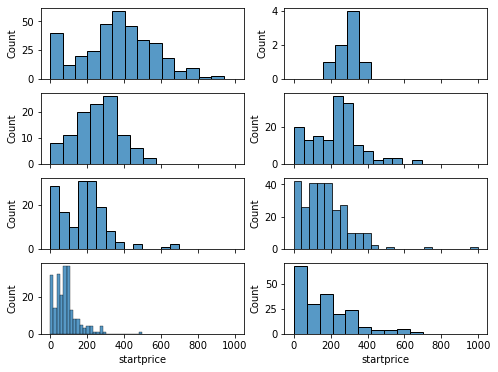

In [215]:
draw_startprice_distribution_by_color('', exclude=True)

### 색상별로 buying rate 차이는 존재할까?

In [219]:
[(unq, df[df['color']==unq]['sold'].mean()) for unq in df.color.unique()]

[('White', 0.43597560975609756),
 (nan, nan),
 ('Space Gray', 0.45),
 ('Midnight Black', 0.5583941605839416),
 ('Aura Black', 0.3157894736842105),
 ('Gold', 0.34615384615384615),
 ('Black', 0.42105263157894735),
 ('Prism Black', 0.0)]

# `startprice` & `sold`
- `sold` = target label
- 경매 낙찰되거나 즉시구매가 지불하면 1, 낙찰에 실패하면 0
    - 경매참여자들이 제시한 금액이 마감시한까지 판매자 기대에 못 미치면 판매 실패
    - 경매에 성공한 상품 vs. 경매에 실패한 상품
    
> 각 제품 모델 및 중고여부에 따른 startprice 싯가가 존재할 것이라고 가정

> 각 제품 모델 및 중고여부에 따른 startprice 싯가에 대한 up & down 정보를 변수로 만들어보면 어떨까?

In [222]:
df_sold = df[df['sold']==1]
df_not_sold = df[df['sold']==0]

<AxesSubplot:xlabel='productline', ylabel='startprice'>

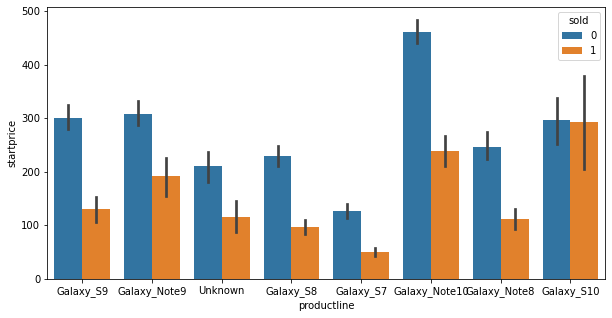

In [239]:
# startprice 평균값 기준으로 비교
plt.figure(figsize=(10, 5))
sns.barplot(data=df,
            x="productline",
            y="startprice",
            hue="sold")

<AxesSubplot:xlabel='productline', ylabel='startprice'>

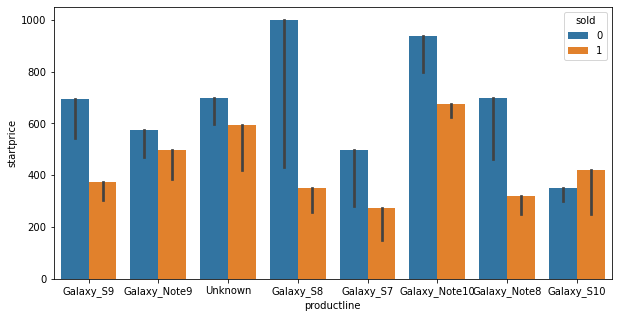

In [240]:
# startprice 최대값 기준 비교
plt.figure(figsize=(10, 5))
sns.barplot(data=df,
            x="productline",
            y="startprice",
            hue="sold",
           estimator=np.max)

<AxesSubplot:xlabel='productline', ylabel='startprice'>

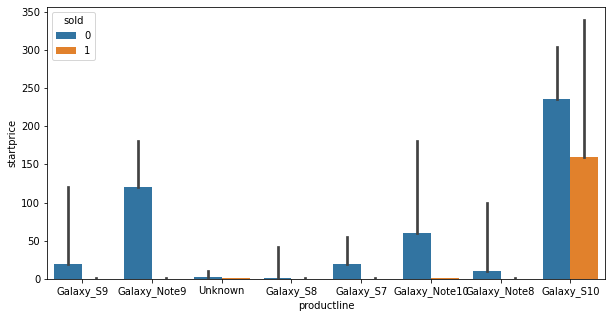

In [241]:
# startprice 최소 기준 비교
plt.figure(figsize=(10, 5))
sns.barplot(data=df,
            x="productline",
            y="startprice",
            hue="sold",
           estimator=np.min)

In [266]:
df.groupby(['productline', 'BuyItNow'])['startprice'].mean()

productline    BuyItNow
Galaxy_Note10  0           456.760190
               1           231.546357
Galaxy_Note8   0           244.691316
               1           108.330000
Galaxy_Note9   0           319.772131
               1           168.086304
Galaxy_S10     0           313.810000
               1           160.000000
Galaxy_S7      0           115.739633
               1            55.046695
Galaxy_S8      0           232.980426
               1            96.319412
Galaxy_S9      0           300.376237
               1           132.390308
Unknown        0           213.413583
               1           112.823810
Name: startprice, dtype: float64

In [252]:
df[df['startprice'] < 50]

,BuyItNow,startprice,color,productline,hasDescription,upperCaseDescription,sold,modelNumber,isNote
5,1,0.99,White,Galaxy_S7,0,0,1,1,0
9,1,20.00,Midnight Black,Galaxy_S7,1,1,1,1,0
28,1,49.00,Aura Black,Galaxy_Note10,0,0,1,4,1
79,1,45.00,NaN,Galaxy_Note8,1,1,1,2,1
103,1,9.99,White,Galaxy_Note8,0,0,1,2,1
...,...,...,...,...,...,...,...,...,...
1439,1,49.99,Midnight Black,Galaxy_S7,1,1,1,1,0
1441,0,36.95,NaN,Galaxy_S7,1,1,1,1,0
1458,1,49.95,White,Galaxy_S8,1,1,1,2,0
1460,1,0.99,White,Galaxy_S9,1,1,1,3,0


# Missing Value Analysis
- productline `Unknown`
    - 신품 상태의 mean startprice = 213
    - 중고 상태의 mean startprice = 112
    > mean startprice 기준으로 Galaxy_S8(신품232, 중고96)과 매우 유사함
- manual imputation 가능한지 추가적인 조사를 진행

In [268]:
df.groupby(['productline', 'BuyItNow'])['startprice'].mean()

productline    BuyItNow
Galaxy_Note10  0           456.760190
               1           231.546357
Galaxy_Note8   0           244.691316
               1           108.330000
Galaxy_Note9   0           319.772131
               1           168.086304
Galaxy_S10     0           313.810000
               1           160.000000
Galaxy_S7      0           115.739633
               1            55.046695
Galaxy_S8      0           232.980426
               1            96.319412
Galaxy_S9      0           300.376237
               1           132.390308
Unknown        0           213.413583
               1           112.823810
Name: startprice, dtype: float64

In [291]:
df.groupby(['productline', 'BuyItNow'])['startprice'].count()

productline    BuyItNow
Galaxy_Note10  0           211
               1           140
Galaxy_Note8   0            76
               1            77
Galaxy_Note9   0            61
               1            46
Galaxy_S10     0             7
               1             1
Galaxy_S7      0           109
               1           118
Galaxy_S8      0           141
               1           136
Galaxy_S9      0            93
               1            65
Unknown        0           120
               1            84
Name: startprice, dtype: int64

In [273]:
df['productline'].unique()

array(['Galaxy_S9', 'Galaxy_Note9', 'Unknown', 'Galaxy_S8', 'Galaxy_S7',
       'Galaxy_Note10', 'Galaxy_Note8', 'Galaxy_S10'], dtype=object)

In [312]:
pd.concat([df[df['productline']=='Galaxy_S8']['startprice'].describe(),
           df[df['productline']=='Unknown']['startprice'].describe()],
          axis=1)

,startprice,startprice
count,277.000000,204.000000
mean,165.883321,171.994265
std,123.743959,156.092171
min,0.010000,0.990000
25%,89.990000,44.997500
50%,155.000000,149.990000
75%,230.000000,259.992500
max,999.000000,700.000000


<AxesSubplot:xlabel='startprice', ylabel='Count'>

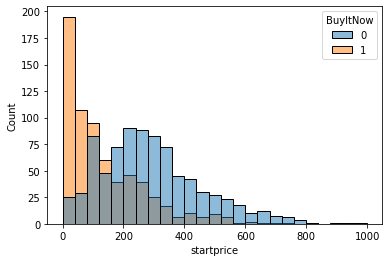

In [347]:
sns.histplot(data=df, x='startprice', hue='BuyItNow')

<AxesSubplot:xlabel='startprice', ylabel='Count'>

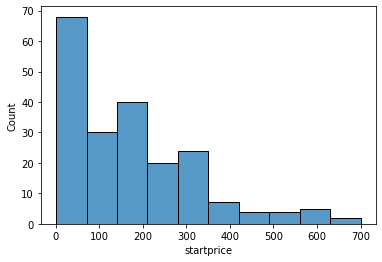

In [361]:
sns.histplot(data=df[df['productline']=='Unknown'], x='startprice')

<AxesSubplot:xlabel='startprice', ylabel='Count'>

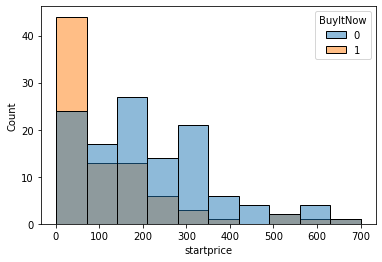

In [338]:
sns.histplot(data=df[df['productline']=='Unknown'], x='startprice', hue='BuyItNow')

<AxesSubplot:xlabel='startprice', ylabel='Count'>

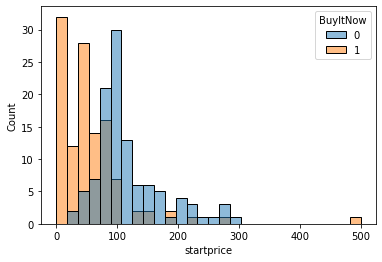

In [348]:
sns.histplot(data=df[df['productline']=='Galaxy_S7'], x='startprice', hue='BuyItNow')

<AxesSubplot:xlabel='startprice', ylabel='Count'>

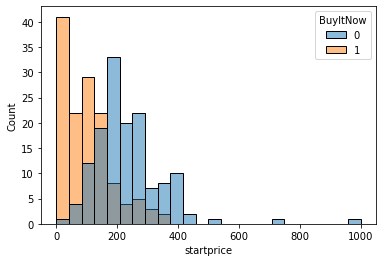

In [285]:
sns.histplot(data=df[df['productline']=='Galaxy_S8'], x='startprice', hue='BuyItNow')

<AxesSubplot:xlabel='startprice', ylabel='Count'>

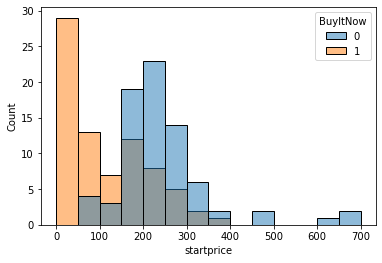

In [350]:
sns.histplot(data=df[df['productline']=='Galaxy_Note8'], x='startprice', hue='BuyItNow')

<AxesSubplot:xlabel='startprice', ylabel='Count'>

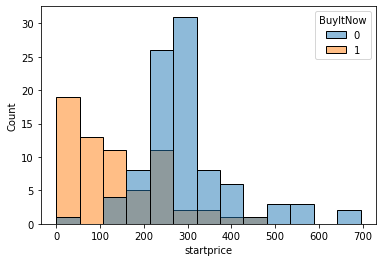

In [351]:
sns.histplot(data=df[df['productline']=='Galaxy_S9'], x='startprice', hue='BuyItNow')

<AxesSubplot:xlabel='startprice', ylabel='Count'>

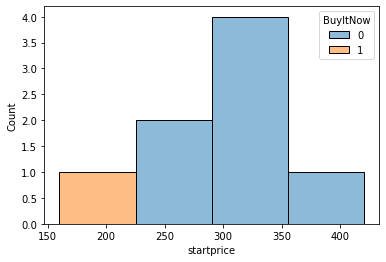

In [292]:
sns.histplot(data=df[df['productline']=='Galaxy_S10'], x='startprice', hue='BuyItNow')

<AxesSubplot:xlabel='startprice', ylabel='Count'>

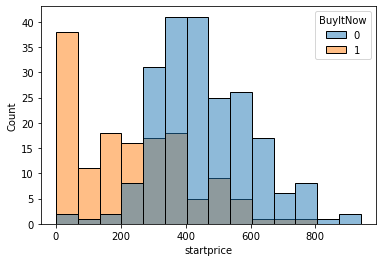

In [290]:
sns.histplot(data=df[df['productline']=='Galaxy_Note10'], x='startprice', hue='BuyItNow')

### `productline`='Unknown'과 유사하다고 보여지는 후보 모델:
- Galaxy S10
    - 이상할 정도로 전체 데이터에서 표본량이 적음 (약 1500개 중 8개)
    - Galaxy Note10의 startprice 분포가 unknown model의 startprice 분포와 유사
- Galaxy S8
    - 평균, 최대, 최소, 표준편차 등 통계량이 유사함



# 분포 간 거리 계산 (scipy.stats)
https://data-newbie.tistory.com/172
- https://www.youtube.com/watch?v=U7xdiGc7IRU&feature=youtu.be

In [328]:
from scipy import stats
#np.random.seed(12345678)  #fix random seed to get the same result
n1 = 200  # size of first sample
n2 = 300  # size of second sample
rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1)
rvs2 = stats.norm.rvs(size=n2, loc=0, scale=1)
stats.ks_2samp(rvs1, rvs2)

KstestResult(statistic=0.06666666666666667, pvalue=0.6434024642847775)

In [329]:
stats.ks_2samp([1,2,3,4,5], [1,2,3,4,5])

KstestResult(statistic=0.0, pvalue=1.0)

In [337]:
# 전체 startprice 분포 vs. unknown product의 startprice 분포
stats.ks_2samp(df[df['productline']=='Unknown']['startprice'],
              df['startprice'])

KstestResult(statistic=0.1484452366805308, pvalue=0.0006448479755540859)

In [334]:
df_product_unknown_startprice = df[df['productline']=='Unknown']['startprice']
df_product_S8_startprice = df[df['productline']=='Galaxy_S8']['startprice']
df_product_Note8_startprice = df[df['productline']=='Galaxy_Note8']['startprice']
df_product_S9_startprice = df[df['productline']=='Galaxy_S9']['startprice']
df_product_Note9_startprice = df[df['productline']=='Galaxy_Note9']['startprice']
df_product_S10_startprice = df[df['productline']=='Galaxy_S10']['startprice']
df_product_Note10_startprice = df[df['productline']=='Galaxy_Note10']['startprice']

statprices_to_compare = [df_product_S8_startprice,
                        df_product_Note8_startprice,
                        df_product_S9_startprice,
                        df_product_Note9_startprice,
                        df_product_S10_startprice,
                        df_product_Note10_startprice
                        ]
statprices_to_compare_modelnames = ['S8', 'Note8', 'S9', 'Note9', 'S10', 'Note10']

In [335]:
from scipy.stats import ks_2samp, wasserstein_distance, energy_distance

In [336]:
for (name, sp) in zip(statprices_to_compare_modelnames, statprices_to_compare):
    print(name)
    print(f'''
        Kolmogorov-Smirnov Distance : {ks_2samp(df_product_unknown_startprice, sp)}
        Wasserstein Distance : {wasserstein_distance(df_product_unknown_startprice, sp)}
        Crammer Distance : {energy_distance(df_product_unknown_startprice, sp)}
    ''')
    print('---')
    
### S8이 startprice 분포 기준으로 가장 유사한 것으로 나타남.

S8

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.1234515466836554, pvalue=0.04998390093987126)
        Wasserstein Distance : 35.03334058894317
        Crammer Distance : 2.139009164130903
    
---
Note8

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.19281045751633988, pvalue=0.002622834864688839)
        Wasserstein Distance : 43.01949346405228
        Crammer Distance : 3.0233393832860145
    
---
S9

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.3277488210474063, pvalue=5.478415943116488e-09)
        Wasserstein Distance : 63.28339600397121
        Crammer Distance : 5.306616928008235
    
---
Note9

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.38308594465823714, pvalue=1.0124366900399195e-09)
        Wasserstein Distance : 91.14758979292652
        Crammer Distance : 6.780660799426887
    
---
S10

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.5857843137254902, pvalue=0.004992728514796263)
      

# Summary.
- `BuyItNow`
    - BuyItNow=1일 때의 startprice가 BuyItNow=0일 때의 startprice보다 2배 가량 낮다.
        - 즉시구매가격을 설정한 셀러는 즉시구매가에 팔고 싶은 사람들
        - 높은 가격을 받기에는 경매가 유리한데, 왜 즉시구매가격을 설정할까?
    - [웹사이트 확인 결과](http://ebay.auction.co.kr/shop/itms?sk_idx=0&q=galaxy%20s7&sk=galaxy%20s7&ltype=Auction), 즉시구매가 설정된 제품 대부분은 "중고 제품", 경매 only 제품 대부분은 "미사용 제품"
        - 일정한 중고거래가 consensus 형성되어 있으므로 즉시구매가를 설정
        - 중고 제품이므로 미사용 제품 대비 가격대가 낮게 설정됨
    > BuyItNow는 중고 매물 여부 정보를 포함하며, 가격에 중요한 설명력을 갖는 변수.
- `productline`
    - productline `Unknown` = 결측치 (약 200개 존재)
        - (BuyItNow=0, productline=Unknown) mean startprice = 213
        - (BuyItNow=1, productline=Unknown) mean startprice = 112
        - mean startprice 기준 Galaxy_S8(신품232, 중고96)과 유사
        - 분포 유사도 측정 척도(Kolmogorov-Smirnov Distance 등)에서도 S8과 가장 유사한 결과
    - 'Unknown'을 'Galaxy_S8'로 imputation 진행
    - productline 정보는 모델이 출시된 시간 정보와 제품 정보가 혼합된 상태
        - 결측치 대체 후 `modelNumber`(ordinal), `isNote`(binary) 2개 컬럼을 생성
        - DROP
- `charCountDescription`, `charCountDescription`
    - 있냐, 없냐 정보만을 표시하는 binary type으로 변경
    - 따라서 `charCountDescription`은 `noDescription`과 동일한 정보가 되므로 drop
- `noDescription`
    - 설명 텍스트가 없으면 'contains description', 있으면 'no description'으로 표현
    - binarize
        - contains description = 0
        - no description = 1
- `carrier`
    - 유의미한 정보를 갖고 있지 않음
    - missing value imputation 가치 없음
    > DROP
- `startprice` & `sold`
    - `sold` = target label
    - 경매 낙찰되거나 즉시구매가 지불하면 1, 낙찰에 실패하면 0
        - 경매참여자들이 제시한 금액이 마감시한까지 판매자 기대에 못 미치면 판매 실패
        - 경매에 성공한 상품 vs. 경매에 실패한 상품
    - 경매 시장에서 각 모델군(신품/중고)에 대한 기대가격이 존재할 것으로 생각할 수 있음
    - 낙찰 제품(sold=1)의 startprice는 미낙찰 제품(sold=0)의 startprice보다 낮은 수준을 형성
        - 기대가격(싯가)보다 비싸서 낙찰되지 않았다 OR 판매자의 기대가격이 싯가보다 높은 수준이었다
- `color`
    - 제품군별 공식 제품출시정보(domain knowledge)와 비교대조를 통한 정보 신뢰성 검증
    - 부정확한 데이터가 많으며, 결측치도 상당한 수준으로 판단됨
    - DROP


### 혹시 모를 가능성 위해
- `carrier`와 `color`가 결측치인지 아닌지를 구분하는 컬럼을 생성
    - `has_carrier`
    - `has_color`

In [403]:
df = pd.read_csv('./data/galaxy.csv')

In [404]:
df['has_carrier'] = df['carrier'].apply(lambda x: 0 if type(x) != str else 1)
df['has_color'] = df['color'].apply(lambda x: 0 if type(x) != str else 1)

In [407]:
# productline 결측값 대치 전에 has_productline도 별도 컬럼으로 생성
df['has_productline'] = df['productline'].apply(lambda x: 0 if str(x).startswith('U') else 1)

In [408]:
df.loc[df['productline']=='Unknown', 'productline'] = 'Galaxy_S8'
# 출시 시기 정보 - 빨리 나온 순서대로 1부터 ++1 순차 넘버링 (ordinal type)
df['modelNumber'] = df['productline'].apply(lambda x: int(x.split('_')[1].strip('S').strip('Note'))-6
                                            if x != 'Unknown' else x)
# 노트 모델인지 일반 모델인지 정보 (binary type)
df['isNote'] = df['productline'].apply(lambda x: x if x == 'Unknown' else 1 if 'Note' in x else 0)

In [409]:
df = df.drop('charCountDescription', axis=1)
df['upperCaseDescription'] = df['upperCaseDescription'].apply(lambda x: 0 if x == 0 else 1)
df['noDescription'] = df['noDescription'].apply(lambda x: 0 if x.startswith('c') else 1)
df.rename(columns={'noDescription':'hasDescription'}, inplace=True)

In [410]:
df = df.drop(['carrier', 'color', 'productline'], axis=1)
df.head()

,BuyItNow,startprice,hasDescription,upperCaseDescription,sold,has_carrier,has_color,has_productline,modelNumber,isNote
0,0,199.99,0,0,1,1,1,1,3,0
1,0,235.00,0,0,0,1,0,1,3,1
2,0,199.99,1,1,0,0,0,0,2,0
3,1,175.00,0,0,1,1,1,1,3,1
4,1,100.00,0,0,1,1,1,1,2,0


<AxesSubplot:>

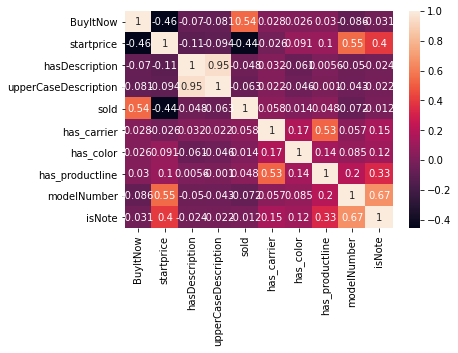

In [411]:
sns.heatmap(df.corr(), annot=True)

In [413]:
df.to_csv('./data/galaxy-cleaned.csv', encoding='utf-8-sig')

In [418]:
df_scaled = pd.concat([df.drop('startprice', axis=1), scaled_df], axis=1)
df_scaled.to_csv('./data/galaxy-cleaned-scaled.csv', encoding='utf-8-sig')

# Standardize

In [414]:
# Get column names first
columns_to_standardize = ['startprice']
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df[columns_to_standardize])
scaled_df = pd.DataFrame(scaled_df, columns=columns_to_standardize)

In [415]:
scaled_df

,startprice
0,-0.097516
1,0.105047
2,-0.097516
3,-0.242105
4,-0.676044
...,...
1480,-0.736796
1481,0.133687
1482,0.654646
1483,-0.739689


<AxesSubplot:xlabel='startprice', ylabel='Count'>

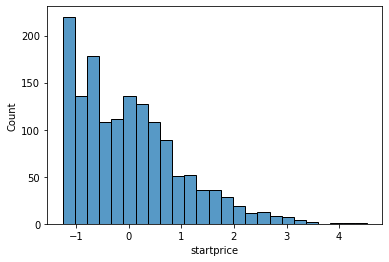

In [416]:
sns.histplot(scaled_df['startprice'])

<AxesSubplot:xlabel='startprice', ylabel='Count'>

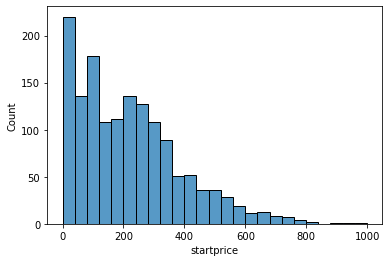

In [417]:
sns.histplot(df['startprice'])

<AxesSubplot:xlabel='charCountDescription', ylabel='Count'>

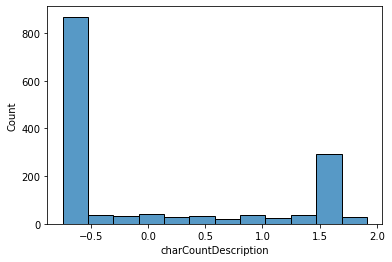

In [8]:
sns.histplot(scaled_df['charCountDescription'])

<AxesSubplot:xlabel='upperCaseDescription', ylabel='Count'>

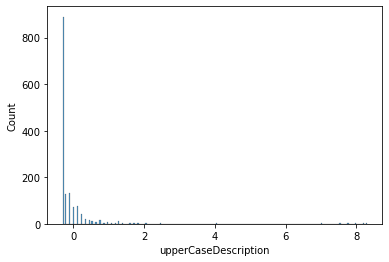

In [9]:
sns.histplot(scaled_df['upperCaseDescription'])